## Problem Set #7
### MACS 30150, Dr. Evans
#### Yongfei Lu,  02/27/2020

### Problem 1
#### (a)

In [5]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv('biden.csv')
df.dropna(inplace=True)
print(df.head())

   biden  female  age  educ  dem  rep
0     90       0   19    12    1    0
1     70       1   51    14    1    0
2     60       0   27    14    0    0
3     50       1   43    14    1    0
4     60       1   38    14    0    1


In [7]:
# split the data
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

y = df['biden'].values
X = df[['female', 'age', 'dem', 'rep', 'educ']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=25)

biden_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_tree.fit(X_train, y_train)


DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

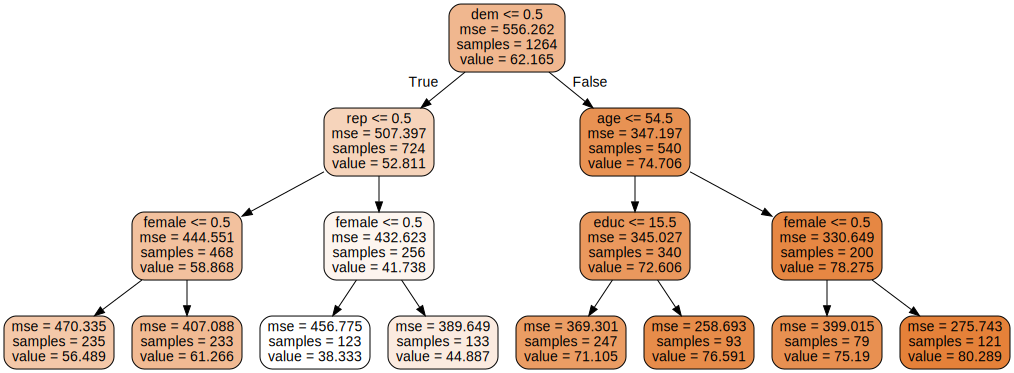

In [8]:
from sklearn.tree import export_graphviz
import graphviz

biden_tree_viz = export_graphviz(
    biden_tree,
    out_file=None,
    feature_names=["female", "age", "dem", "rep", "educ"],
    class_names=df["biden"],
    rounded=True,
    filled=True,
)

graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz')
graph

### Interpertation
Given the five attributes, the algorithom presents the tree with optimal splits. The five attributes that are splited in the order of dem, rep, female, age, and educ. In the bottom, each node represents a partition of feature space.

The decision tree above shows that Democrats tend to have warmer feeling towards Joe Biden than non-Democrats, wh non-Democrats. Female respondents who are over 54.5 years old tend to give Joe Biden the highest feeling scores, while republican male respondents tend to give the lowest feeling scores. Among non-Republicans respondents, there is little difference in the biden scores given by male and female respondents.

In [9]:
from sklearn.metrics import mean_squared_error

y_pred = biden_tree.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
print('the test MSE is {}'.format(MSE))

the test MSE is 396.1937146321307


### (b)

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist1 = {'max_depth': [3,10],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20)}

random_search1 = RandomizedSearchCV(biden_tree, param_distributions=param_dist1,
                                    n_iter=100, n_jobs=-1, cv=5, random_state=25,
                                    scoring='neg_mean_squared_error')

random_search1.fit(X, y)


print('Optimal tuning parameter values:', random_search1.best_params_)
print()
print('MSE of the optimal results:', random_search1.best_score_)



Optimal tuning parameter values: {'max_depth': 3, 'min_samples_leaf': 17, 'min_samples_split': 14}

MSE of the optimal results: -401.6903602232667


### (c)



In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

biden_forest = RandomForestRegressor(bootstrap=True,oob_score=True, random_state=25)
biden_forest.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=True, random_state=25, verbose=0,
                      warm_start=False)

In [12]:
param_dist2 = { 'n_estimators': [10, 200],
                'max_depth': [3, 10],
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20),
                'max_features': sp_randint(1, 5)}


random_search2 = RandomizedSearchCV(biden_forest, param_distributions=param_dist2,
                                    n_iter=100, n_jobs=-1, cv=5, random_state=25,
                                    scoring='neg_mean_squared_error')

random_search2.fit(X,y)

print('Optimal tuning parameter values:\n', random_search2.best_params_)
print()
print('MSE of optimal results:\n', -random_search2.best_score_)

Optimal tuning parameter values:
 {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 19, 'min_samples_split': 2, 'n_estimators': 200}

MSE of optimal results:
 397.2581460664323


### Problem 2
#### (a)

In [13]:
df_2 = pd.read_csv('Auto.csv',na_values="?")
df_2.dropna(inplace=True)
df_2["mpg_high"] = (df_2['mpg'] > df_2['mpg'].median()).astype(int)
df_2['origin1'] = (df_2['origin'] == 1).astype(int)
df_2['origin2'] = (df_2['origin'] == 2).astype(int)
df_2['const']=1
df_2.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_high,origin1,origin2,const
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0,1,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0,1,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0,1,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0,1,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0,1,0,1


In [14]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

y = df_2["mpg_high"]
X = df_2[["cylinders","displacement","horsepower",
          "weight","acceleration","year","origin1","origin2"]]

kf_log = KFold(n_splits=4, shuffle=True, random_state=25)
kf_log.get_n_splits(X.values)
err_vec1 = np.zeros(4)
err_vec0 = np.zeros(4)
MSE_vec_kf = np.zeros(4)
k_ind = int(0)

for train_index, test_index in kf_log.split(X.values):
    
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    err_1_pred = np.sum((y_test!=y_pred)&(y_test == 1)) \
    /np.sum(y_test == 1)
    err_0_pred = np.sum((y_test!=y_pred)&(y_test == 0)) \
    /np.sum(y_test == 0)
    err_vec1[k_ind] = err_1_pred
    err_vec0[k_ind] = err_0_pred
    MSE_vec_kf[k_ind] = (y_test != y_pred).mean()
    
    print('MSE for test set k = ', k_ind, ' is', MSE_vec_kf[k_ind])
    print('error rate for mpg_high = 1 of test set', \
          k_ind, ' is', err_1_pred)
    print('error rate for mpg_high = 0 of test set', \
          k_ind, ' is', err_0_pred)
    print()
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
err_1 = err_vec1.mean()
err_0 = err_vec0.mean()
print('The estimate MSE loocv of the test :', MSE_kf)
print('Overall error rate for mpg_high = 1 :', err_1)
print('Overall error rate for mpg_high = 0 :', err_0)   


MSE for test set k =  0  is 0.14285714285714285
error rate for mpg_high = 1 of test set 0  is 0.14545454545454545
error rate for mpg_high = 0 of test set 0  is 0.13953488372093023

MSE for test set k =  1  is 0.09183673469387756
error rate for mpg_high = 1 of test set 1  is 0.07317073170731707
error rate for mpg_high = 0 of test set 1  is 0.10526315789473684

MSE for test set k =  2  is 0.07142857142857142
error rate for mpg_high = 1 of test set 2  is 0.043478260869565216
error rate for mpg_high = 0 of test set 2  is 0.09615384615384616

MSE for test set k =  3  is 0.08163265306122448
error rate for mpg_high = 1 of test set 3  is 0.05555555555555555
error rate for mpg_high = 0 of test set 3  is 0.11363636363636363

The estimate MSE loocv of the test : 0.09693877551020408
Overall error rate for mpg_high = 1 : 0.07941477339674582
Overall error rate for mpg_high = 0 : 0.11364706285146922


### (b)


In [16]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

X_b = df_2[["cylinders","displacement","horsepower",
            "weight","acceleration","year","origin1","origin2"]]
y_b = df_2["mpg_high"]

param_dist3 = { 'n_estimators': [10, 200],
                'max_depth': [3, 8],
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20),
                'max_features': sp_randint(1, 8)}

random_forest2 = RandomForestClassifier(bootstrap=True, oob_score=True, random_state=25)
random_forest2.fit(X_b, y_b)


random_search3 = RandomizedSearchCV(random_forest2, param_distributions=param_dist3,
                                    n_iter=100, n_jobs=-1, cv=4, random_state=25,
                                    scoring='neg_mean_squared_error')
random_search3.fit(X_b, y_b)

print('The optimal tuning parameter values :\n', random_search3.best_params_)
print()
print('The MSE of the optimal results :', -random_search3.best_score_)

The optimal tuning parameter values :
 {'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 10}

The MSE of the optimal results : 0.08928571428571429


### (c)

In [17]:
from sklearn.svm import SVC
from scipy.stats import uniform as sp_uniform

param_dist4 = { 'C': sp_uniform(loc=0.2, scale=4.0),
                'gamma': ['scale', 'auto'],
                'shrinking': [True, False]}

svc = SVC(kernel='rbf')
random_search4 = RandomizedSearchCV(svc, param_distributions=param_dist4,
                                    n_iter=100, n_jobs=-1, cv=4, random_state=25,
                                    scoring='neg_mean_squared_error')
random_search4.fit(X_b, y_b)

print('The optimal tuning parameter values :\n', random_search4.best_params_)
print()
print('The MSE of the optimal results :', -random_search4.best_score_)

The optimal tuning parameter values :
 {'C': 1.8094629152568114, 'gamma': 'scale', 'shrinking': False}

The MSE of the optimal results : 0.11989795918367346


#### (d)
The Random Forest Classifier model with {max_depth = 8, max_features = 3, min_sample_leaf = 15, and min_sample_split = 2} produces the best predictor of mpg_high because it yields the lowest MSE.